## <center> *Модель прогнозирования стоимости жилья для агентства недвижимости*

# <center> **Часть II. Разведывательный анализ и моделирование.**

Импорт библиотек

In [1]:
import pandas as pd
import numpy as np

import scipy.stats as sps

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.preprocessing as pp 
import sklearn.model_selection as ms 
import sklearn.feature_selection as fs

import sklearn.linear_model as lm
import sklearn.tree as tree
import sklearn.ensemble as ens
import sklearn.svm as svm
import sklearn.metrics as m

import lightgbm as lgbm
import xgboost as xgb
import catboost as cb 

from functions import *
import pickle 

import warnings
warnings.filterwarnings('ignore')

plt.style.use('bmh')

R = 7
np.random.seed(R)

## **Данные**

Читаем данные

In [2]:
data = pd.read_csv('data/data_edited.csv')

data

,status for sale,status coming soon,status new,status foreclosure,status pre-foreclosure,status pending,status auction,status active,status show,status for rent,...,school distance mean,school rating nearest,school distance to best,schools with k,schools with pk,schools with preschool,school grades,target per month,target plus,target
0,0,0,0,0,0,0,0,1,0,0,...,5.537500,7,5.10,3,2,0,13,0,0,418.000
1,1,0,0,0,0,0,0,0,0,0,...,1.326667,4,1.65,1,1,0,13,0,0,310.000
2,1,0,0,0,0,0,0,0,0,0,...,1.960000,8,1.19,1,0,0,13,0,0,2895.000
3,1,0,0,0,0,0,0,0,0,0,...,0.752500,9,1.05,1,1,0,13,0,0,2395.000
4,1,0,0,0,0,0,0,0,0,0,...,4.080000,4,3.25,1,1,0,13,0,0,5.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360187,1,0,0,0,0,0,0,0,0,0,...,0.250000,3,0.40,1,1,0,13,0,0,799.000
360188,0,0,0,0,0,0,0,0,0,0,...,16.600000,10,32.10,1,1,0,13,0,0,1249.000
360189,1,0,0,0,0,0,0,0,0,0,...,4.143333,1,0.40,1,1,0,13,0,0,674.999
360190,1,0,0,0,0,0,0,0,0,0,...,0.605000,4,0.48,1,1,0,9,0,0,528.000


In [3]:
get_data_info(data)

,Nulls,Uniques,Dtypes
status for sale,0.0,2,int64
status coming soon,0.0,2,int64
status new,0.0,2,int64
status foreclosure,0.0,2,int64
status pre-foreclosure,0.0,2,int64
...,...,...,...
schools with preschool,0.0,11,int64
school grades,0.0,13,int64
target per month,0.0,2,int64
target plus,0.0,2,int64


## **Разведывательный анализ**

### Исследование бинарных переменных

In [4]:
bin_cols = set()
num_cols = []

for col in data.columns:
    if ('target' not in col) and (data[col].nunique() == 2):
        bin_cols.add(col.split()[0])
    else:
        num_cols.append(col)

bin_cols, num_cols

({'cooling', 'heating', 'parking', 'propertyType', 'status'},
 ['baths',
  'beds',
  'sqft area',
  'property age',
  'property remodeled',
  'p. spaces',
  'lotsize',
  'zipcode national area',
  'zipcode sectional center',
  'zipcode delivery area',
  'city importance',
  'city population rank',
  'school rating sum',
  'school rating mean',
  'school distance nearest',
  'school distance mean',
  'school rating nearest',
  'school distance to best',
  'schools with k',
  'schools with pk',
  'schools with preschool',
  'school grades',
  'target per month',
  'target plus',
  'target'])

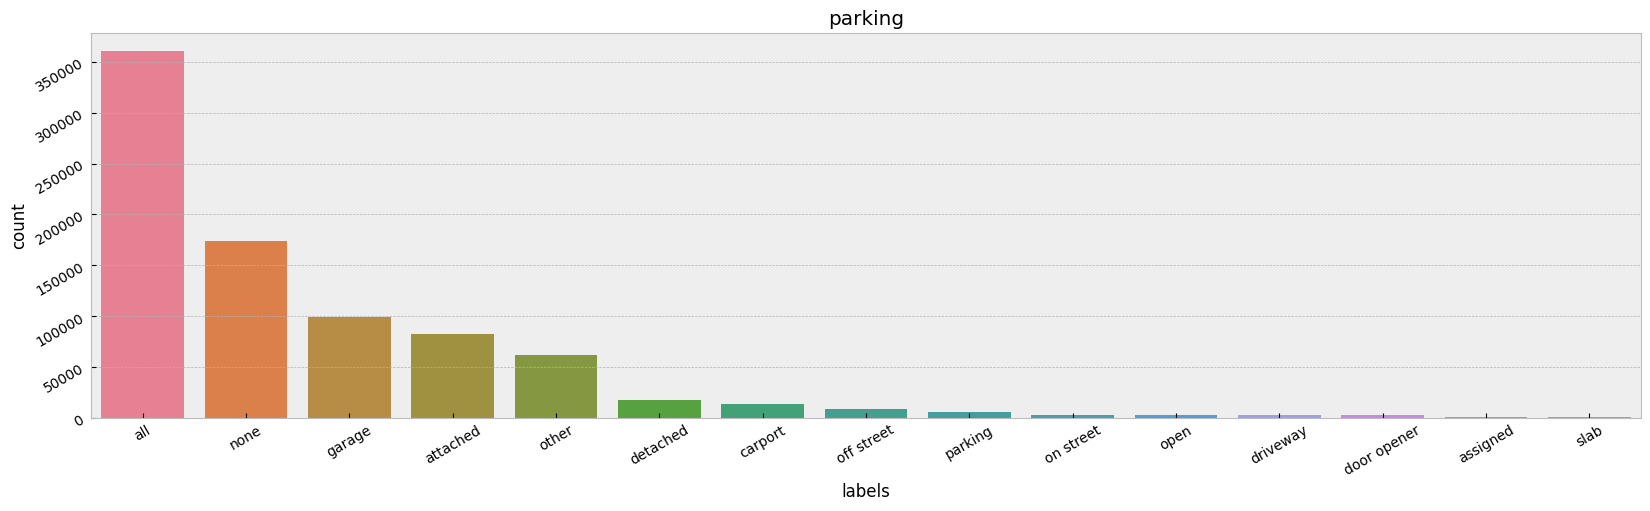

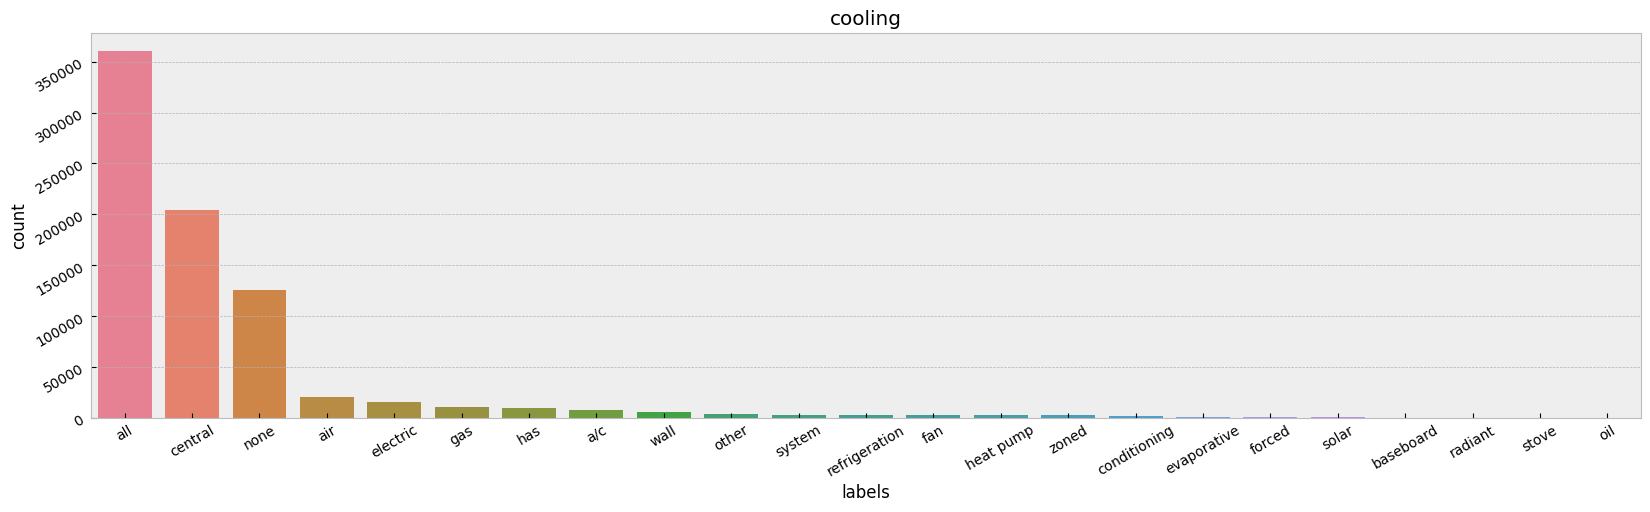

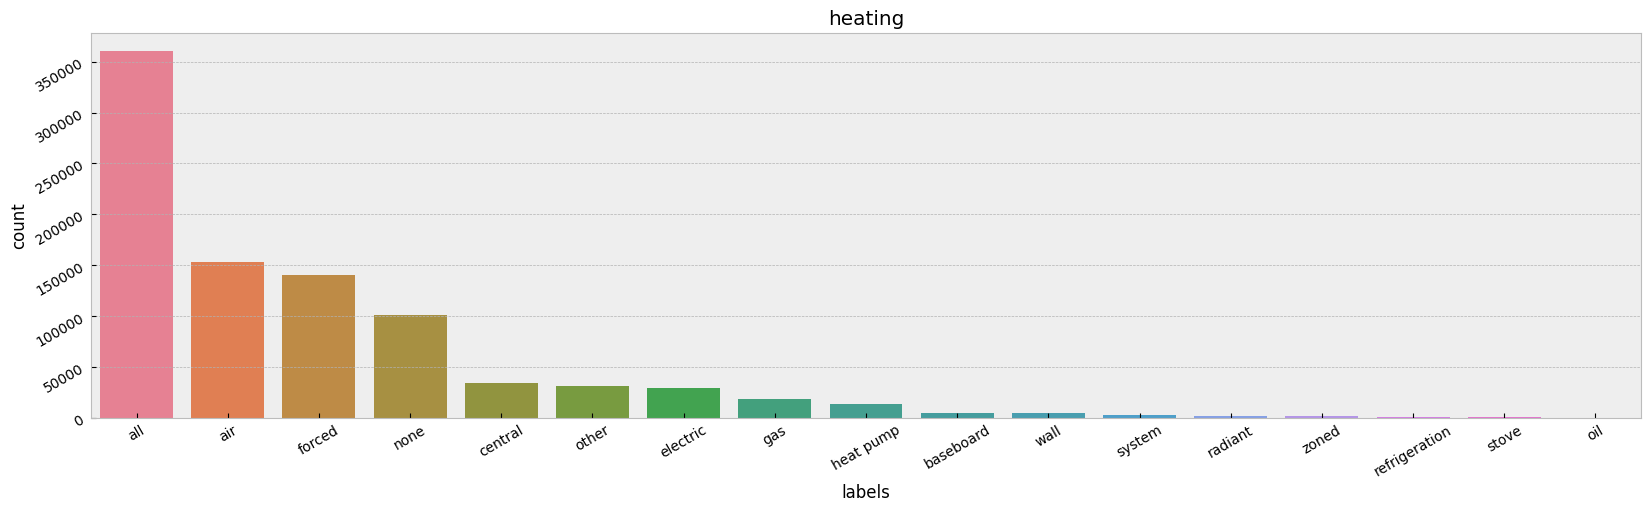

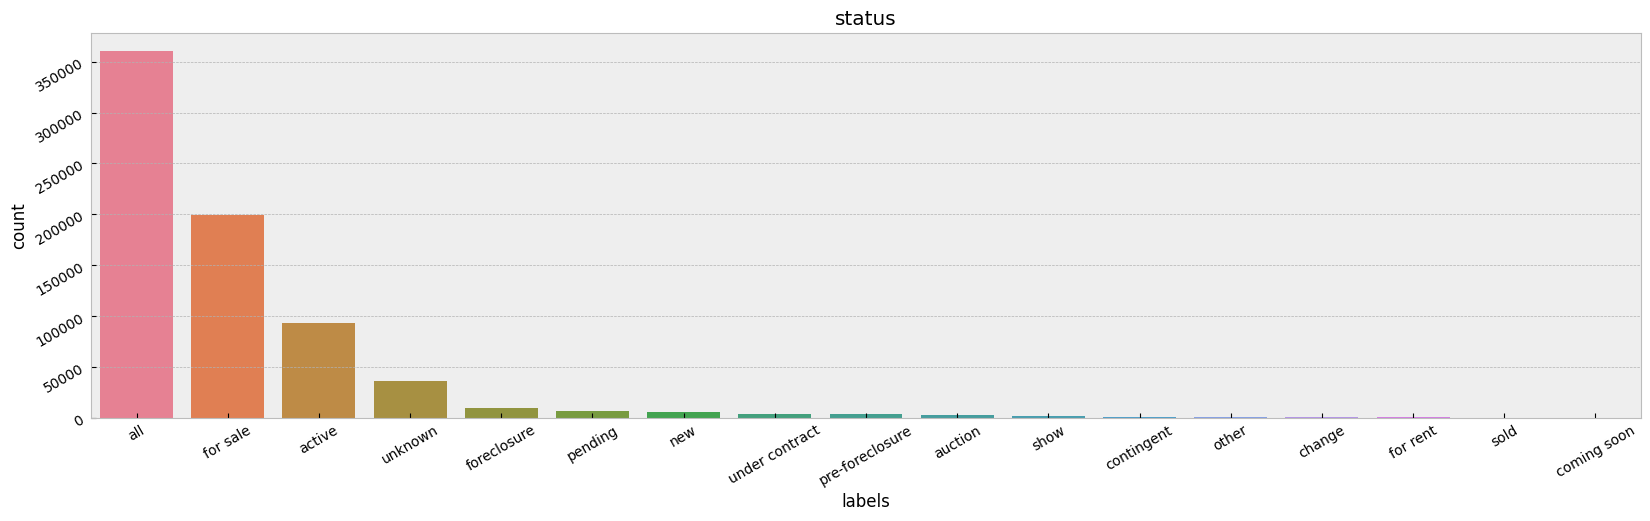

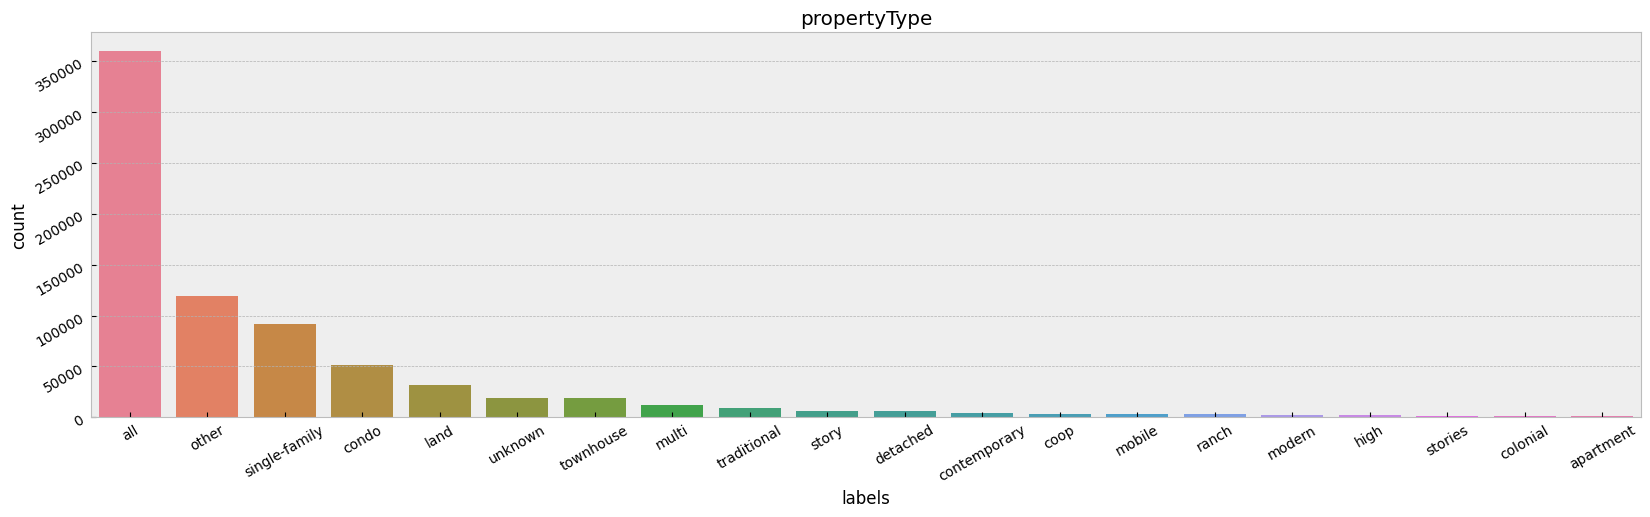

In [5]:
def show_barplot(cols, data=data, figsize=(20, 5)):
    sums = get_sums(data, cols).sort_values(ascending=False)

    col_list = sums.index.tolist() + ['all']
    vls_list = sums.values.tolist() + [data.shape[0]]

    for i in range(len(col_list)):
        col_list[i] = col_list[i].replace(cols+' ', '')

    df = (pd.DataFrame({'labels': col_list, 
                        'count': vls_list})
          .sort_values('count', ascending=False))
    
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(df, x='labels', y='count', hue='labels', ax=ax)
    ax.tick_params(rotation=30)
    ax.set_title(cols)
    
    return fig 


for col in bin_cols:
    show_barplot(col).show()

### Проверка на нормальность

In [6]:
def test_normality(labels, 
                   data=data, 
                   testfunc='shapiro', 
                   alpha=0.05):
    
    norm_df = pd.DataFrame(index=labels)
    
    pv_list = []
    for col in data[labels].columns:
        x = data[col]
        
        if testfunc == 'dagostino':
            p = sps.normaltest(x)
            pv = round(p.pvalue[0], 3)
            alpha = alpha / 2

        p = sps.shapiro(x)
        pv = round(p.pvalue, 3)
        
        pv_list.append(pv)
    
    norm_df['p_value'] = pv_list
    norm_df['is_normal'] = norm_df['p_value'].apply(lambda pv: 'normal' if pv > alpha else 'not normal')

    return norm_df

In [7]:
test_normality(num_cols)

,p_value,is_normal
baths,0.0,not normal
beds,0.0,not normal
sqft area,0.0,not normal
property age,0.0,not normal
property remodeled,0.0,not normal
p. spaces,0.0,not normal
lotsize,1.0,normal
zipcode national area,0.0,not normal
zipcode sectional center,0.0,not normal
zipcode delivery area,0.0,not normal


### Выявление и очистка выбросов 

Shape of cleaned data is (305219, 112).
54973 outliers were dropped.


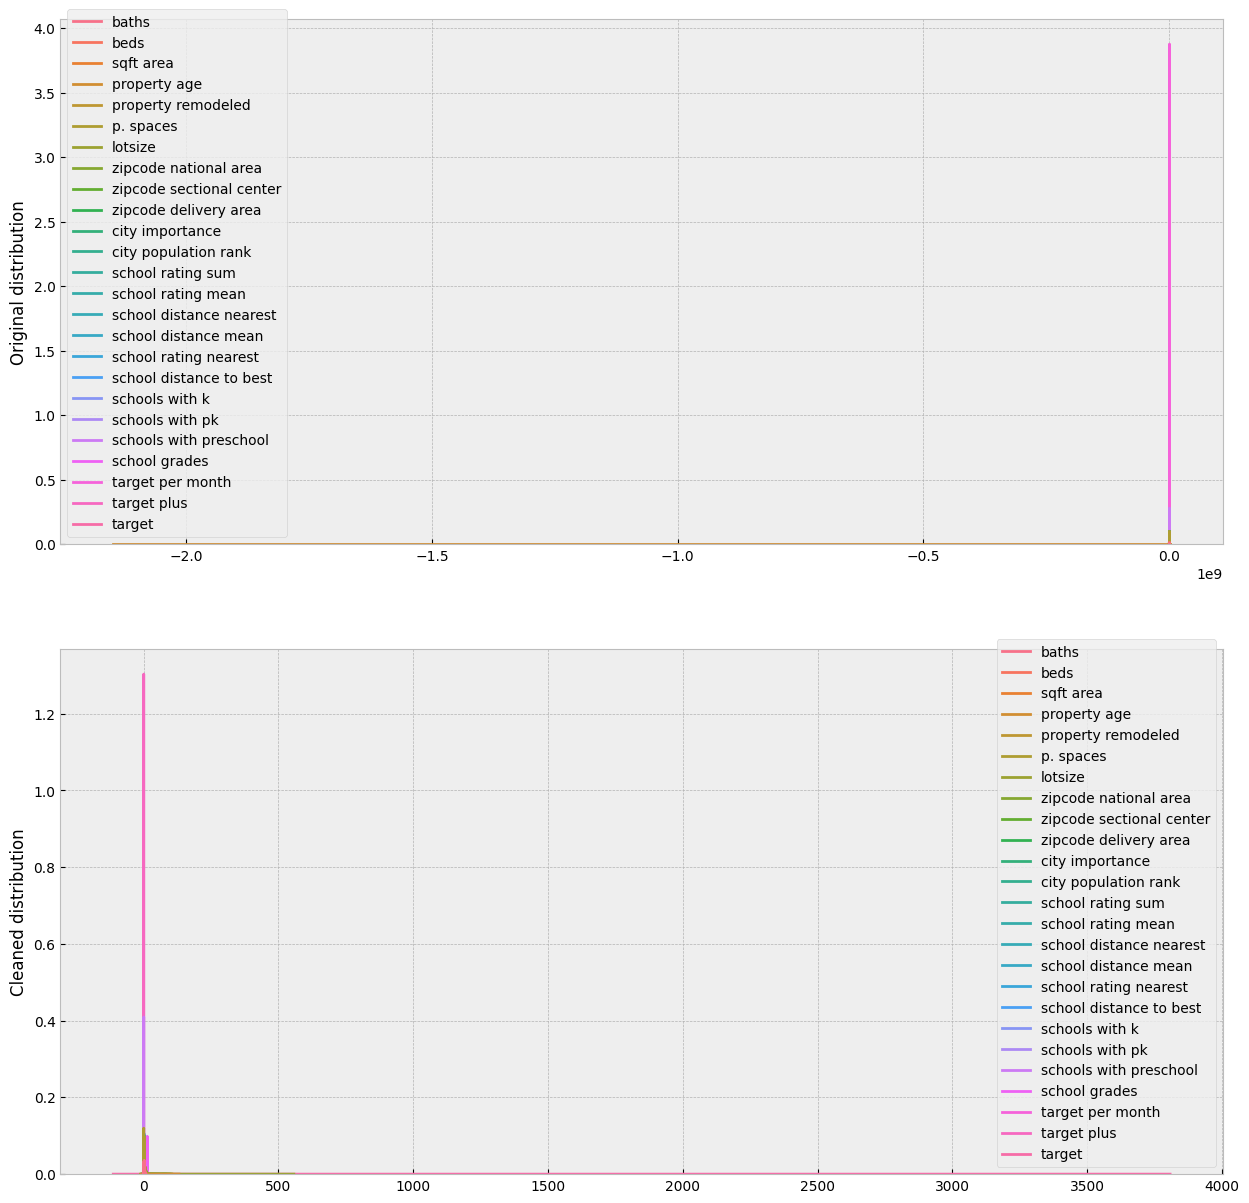

In [8]:
def clean_data(features, data=data, q_limit=0.99, show_plot=False):
    cleaned = data.copy()
    
    for feature in features:
        x = cleaned[feature]

        lim = x.quantile(q_limit)
        cleaned = cleaned[x <= lim][x >= -lim].reset_index(drop=True)
        
    print(f'Shape of cleaned data is {cleaned.shape}.')
    print(f'{data.shape[0] - cleaned.shape[0]} outliers were dropped.')
        
    if show_plot:
        fig, ax = plt.subplots(2, 1, figsize=(15, 15))
        
        sns.kdeplot(data[features], ax=ax[0])
        ax[0].set_ylabel('Original distribution')

        sns.kdeplot(cleaned[features], ax=ax[1])
        ax[1].set_ylabel('Cleaned distribution')

        fig.show()
    
    return cleaned

cleaned_data = clean_data(num_cols, show_plot=True)

### Проверка на мультиколлинеарность

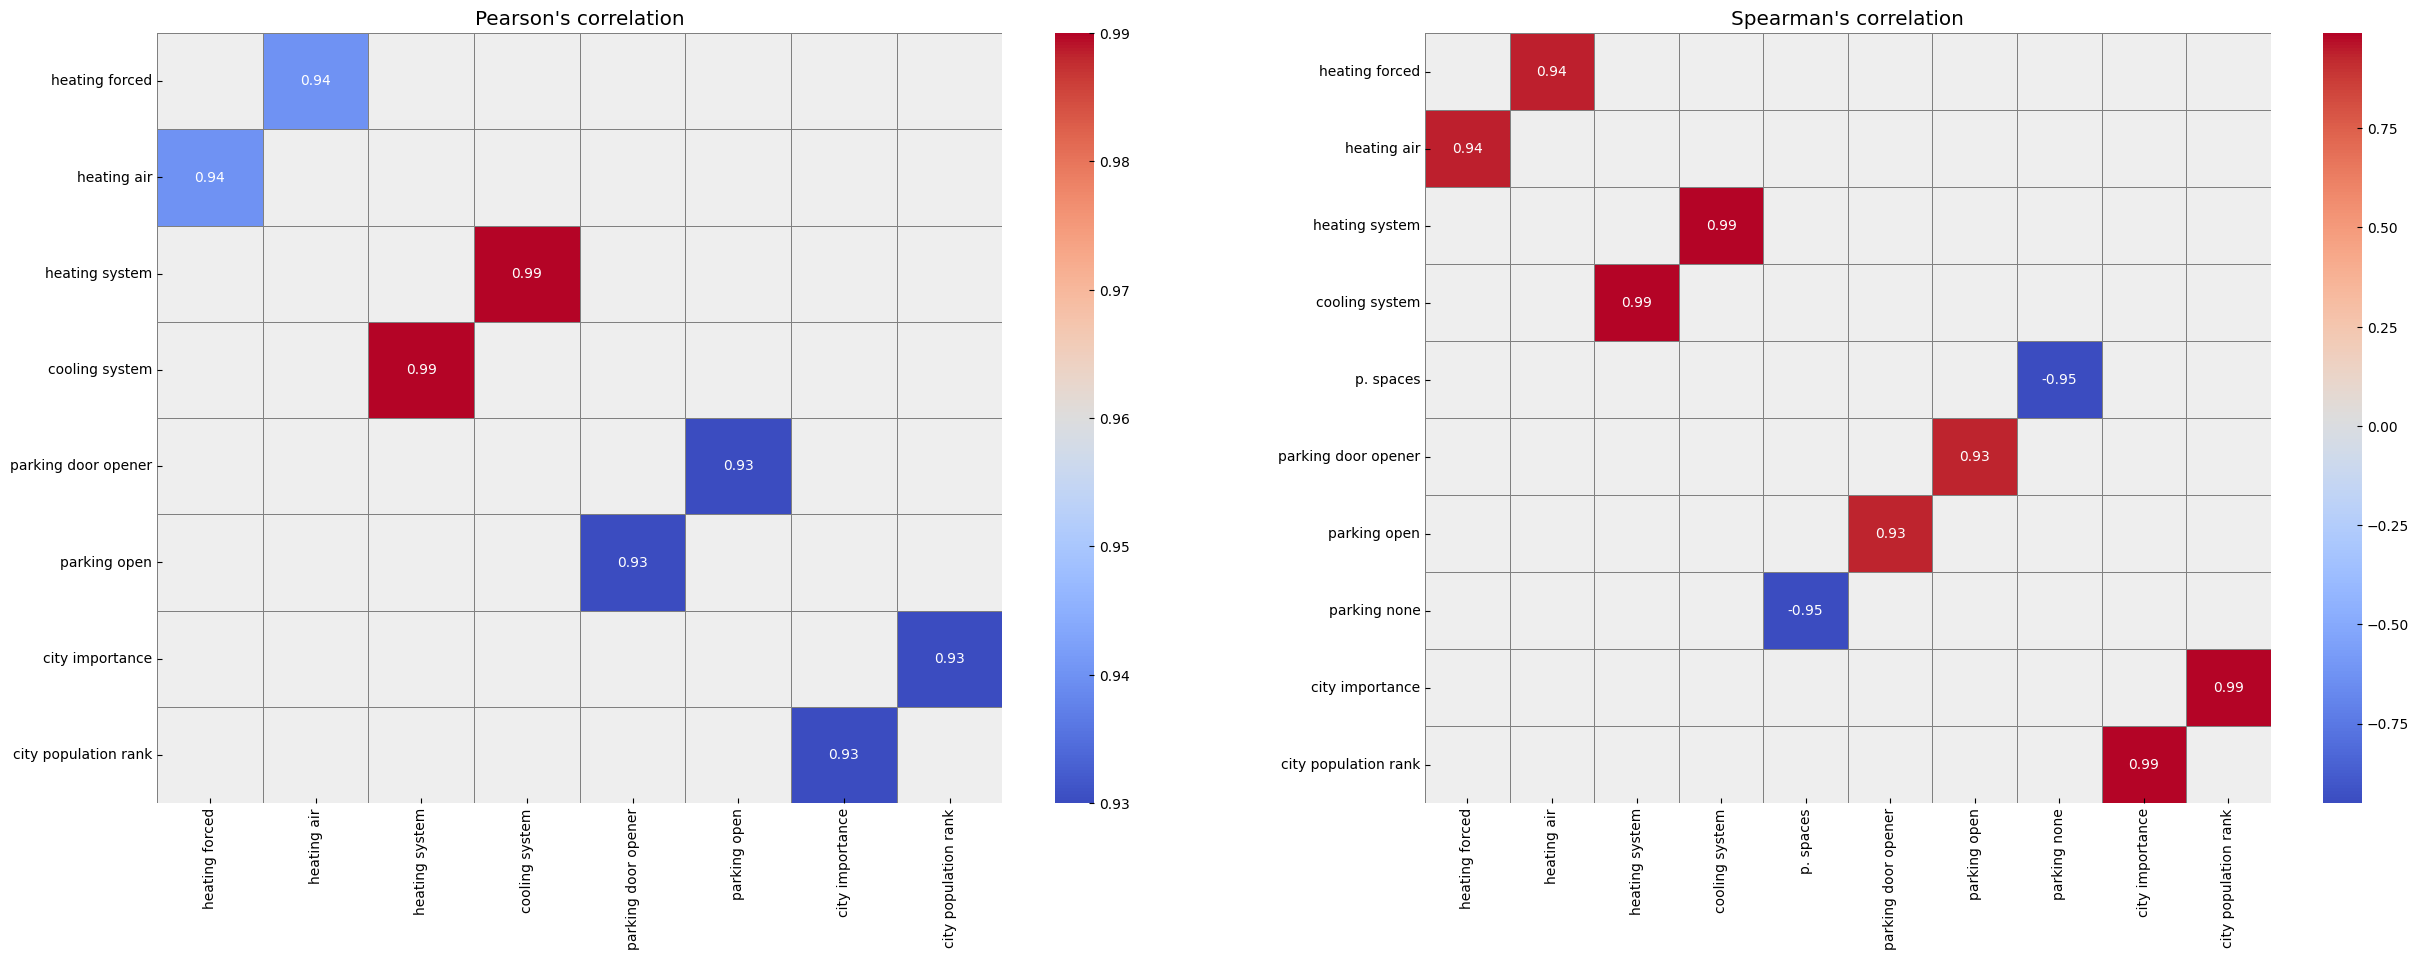

In [9]:
def get_correlations(method, data=cleaned_data):
    corr_data = (data.corr(method=method)
                 [data.corr(method=method).abs() > 0.9]
                 .round(2))

    for i in corr_data.index:
        for c in corr_data.columns:
            if i == c:
                corr_data.loc[i, c] = np.nan

    for i, c in zip(corr_data.index, 
                    corr_data.columns):
        if corr_data.loc[i].sum() == 0:
            corr_data.drop(i, axis=0, inplace=True)
        if corr_data.loc[:, c].sum() == 0:
            corr_data.drop(c, axis=1, inplace=True)
            
    return corr_data


fig, ax = plt.subplots(1, 2, figsize=(30, 10))

sns.heatmap(get_correlations('pearson'), 
            annot=True, 
            cmap='coolwarm', 
            linewidths=.5, 
            linecolor='grey', 
            ax=ax[0])
ax[0].set_title("Pearson's correlation")

sns.heatmap(get_correlations('spearman'), 
            annot=True, 
            cmap='coolwarm', 
            linewidths=.5, 
            linecolor='grey', 
            ax=ax[1])
ax[1].set_title("Spearman's correlation")
    
fig.show()

In [10]:
multicollinear_cols = ['heating forced', 'cooling system', 'parking none', 
                       'parking door opener', 'city importance']

cleaned_data.drop(multicollinear_cols, axis=1, inplace=True)

cleaned_data.shape 

(305219, 107)

### Исследования по выборкам

In [11]:
def binary_stattest(data, alpha=0.05):
    bins_list = []

    for col in data.columns:
        if data[col].nunique() == 2:
            bins_list.append(col)
            
    statdata = pd.DataFrame(index=bins_list)
    pv_list = []
    dep_list = []
            
    for col_ in bins_list:
        sample_1 = data[data[col_] == 1]
        sample_0 = data[data[col_] == 0]
        
        _, p = sps.mannwhitneyu(sample_0['target'], 
                                sample_1['target'])
        pv_list.append(p)
        
        if p > alpha:
            dep_list.append(0)
        else:
            dep_list.append(1)
            
    statdata['pvalue'] = pv_list
    statdata['depends'] = dep_list
    
    return statdata


bs_data = binary_stattest(cleaned_data)

useless_df = bs_data[bs_data['depends'] == 0]

useless_df

,pvalue,depends
heating gas,0.264946,0
heating heat pump,0.082548,0
heating baseboard,0.145930,0
heating stove,0.547098,0
heating refrigeration,0.232886,0
cooling heat pump,0.813783,0
cooling wall,0.060647,0
cooling stove,0.572446,0
cooling oil,0.115968,0
cooling fan,0.077594,0


In [12]:
cleaned_data.drop(useless_df.index, axis=1, inplace=True)

cleaned_data.shape

(305219, 96)

### Исследование числовых переменных

In [13]:
num_cols = []

for col in cleaned_data.columns:
    if cleaned_data[col].nunique() > 2:
        num_cols.append(col)

num_cols.remove('target')

numdata_info = get_data_info(cleaned_data[num_cols])

numdata_info

,Nulls,Uniques,Dtypes
baths,0.0,9,int64
beds,0.0,8,int64
sqft area,0.0,6517,float64
property age,0.0,125,int64
property remodeled,0.0,99,int64
p. spaces,0.0,5,int64
lotsize,0.0,15609,float64
zipcode national area,0.0,10,int64
zipcode sectional center,0.0,94,int64
zipcode delivery area,0.0,93,int64


#### *Категориальные*

In [14]:
cat_cols = numdata_info[numdata_info['Uniques'] <= 20].index.tolist()

cat_cols

['baths',
 'beds',
 'p. spaces',
 'zipcode national area',
 'city population rank',
 'school rating nearest',
 'schools with k',
 'schools with pk',
 'schools with preschool',
 'school grades']

In [15]:
def multiple_stattest(data, cols=cat_cols, alpha=0.05):
    statdata = pd.DataFrame(index=cols)
    pv_list = []
    dep_list = []
    
    for c in cols:
        samples = []

        for i in data[c].unique():
            sample = data[data[c] == i]
            samples.append(sample['target'])
            
        _, p = sps.kruskal(*samples)
        
        pv_list.append(p)
        
        
        if p > alpha:
            dep_list.append(0)
        else:
            dep_list.append(1)
            
    statdata['pvalue'] = pv_list
    statdata['depends'] = dep_list
    
            
    return statdata


multiple_stattest(cleaned_data)

,pvalue,depends
baths,0.0,1
beds,0.0,1
p. spaces,0.0,1
zipcode national area,0.0,1
city population rank,0.0,1
school rating nearest,0.0,1
schools with k,0.0,1
schools with pk,0.0,1
schools with preschool,0.0,1
school grades,0.0,1


#### *Непрерывные*

In [16]:
for cat in cat_cols:
    num_cols.remove(cat)
    
num_cols, len(num_cols) 

(['sqft area',
  'property age',
  'property remodeled',
  'lotsize',
  'zipcode sectional center',
  'zipcode delivery area',
  'school rating sum',
  'school rating mean',
  'school distance nearest',
  'school distance mean',
  'school distance to best'],
 11)

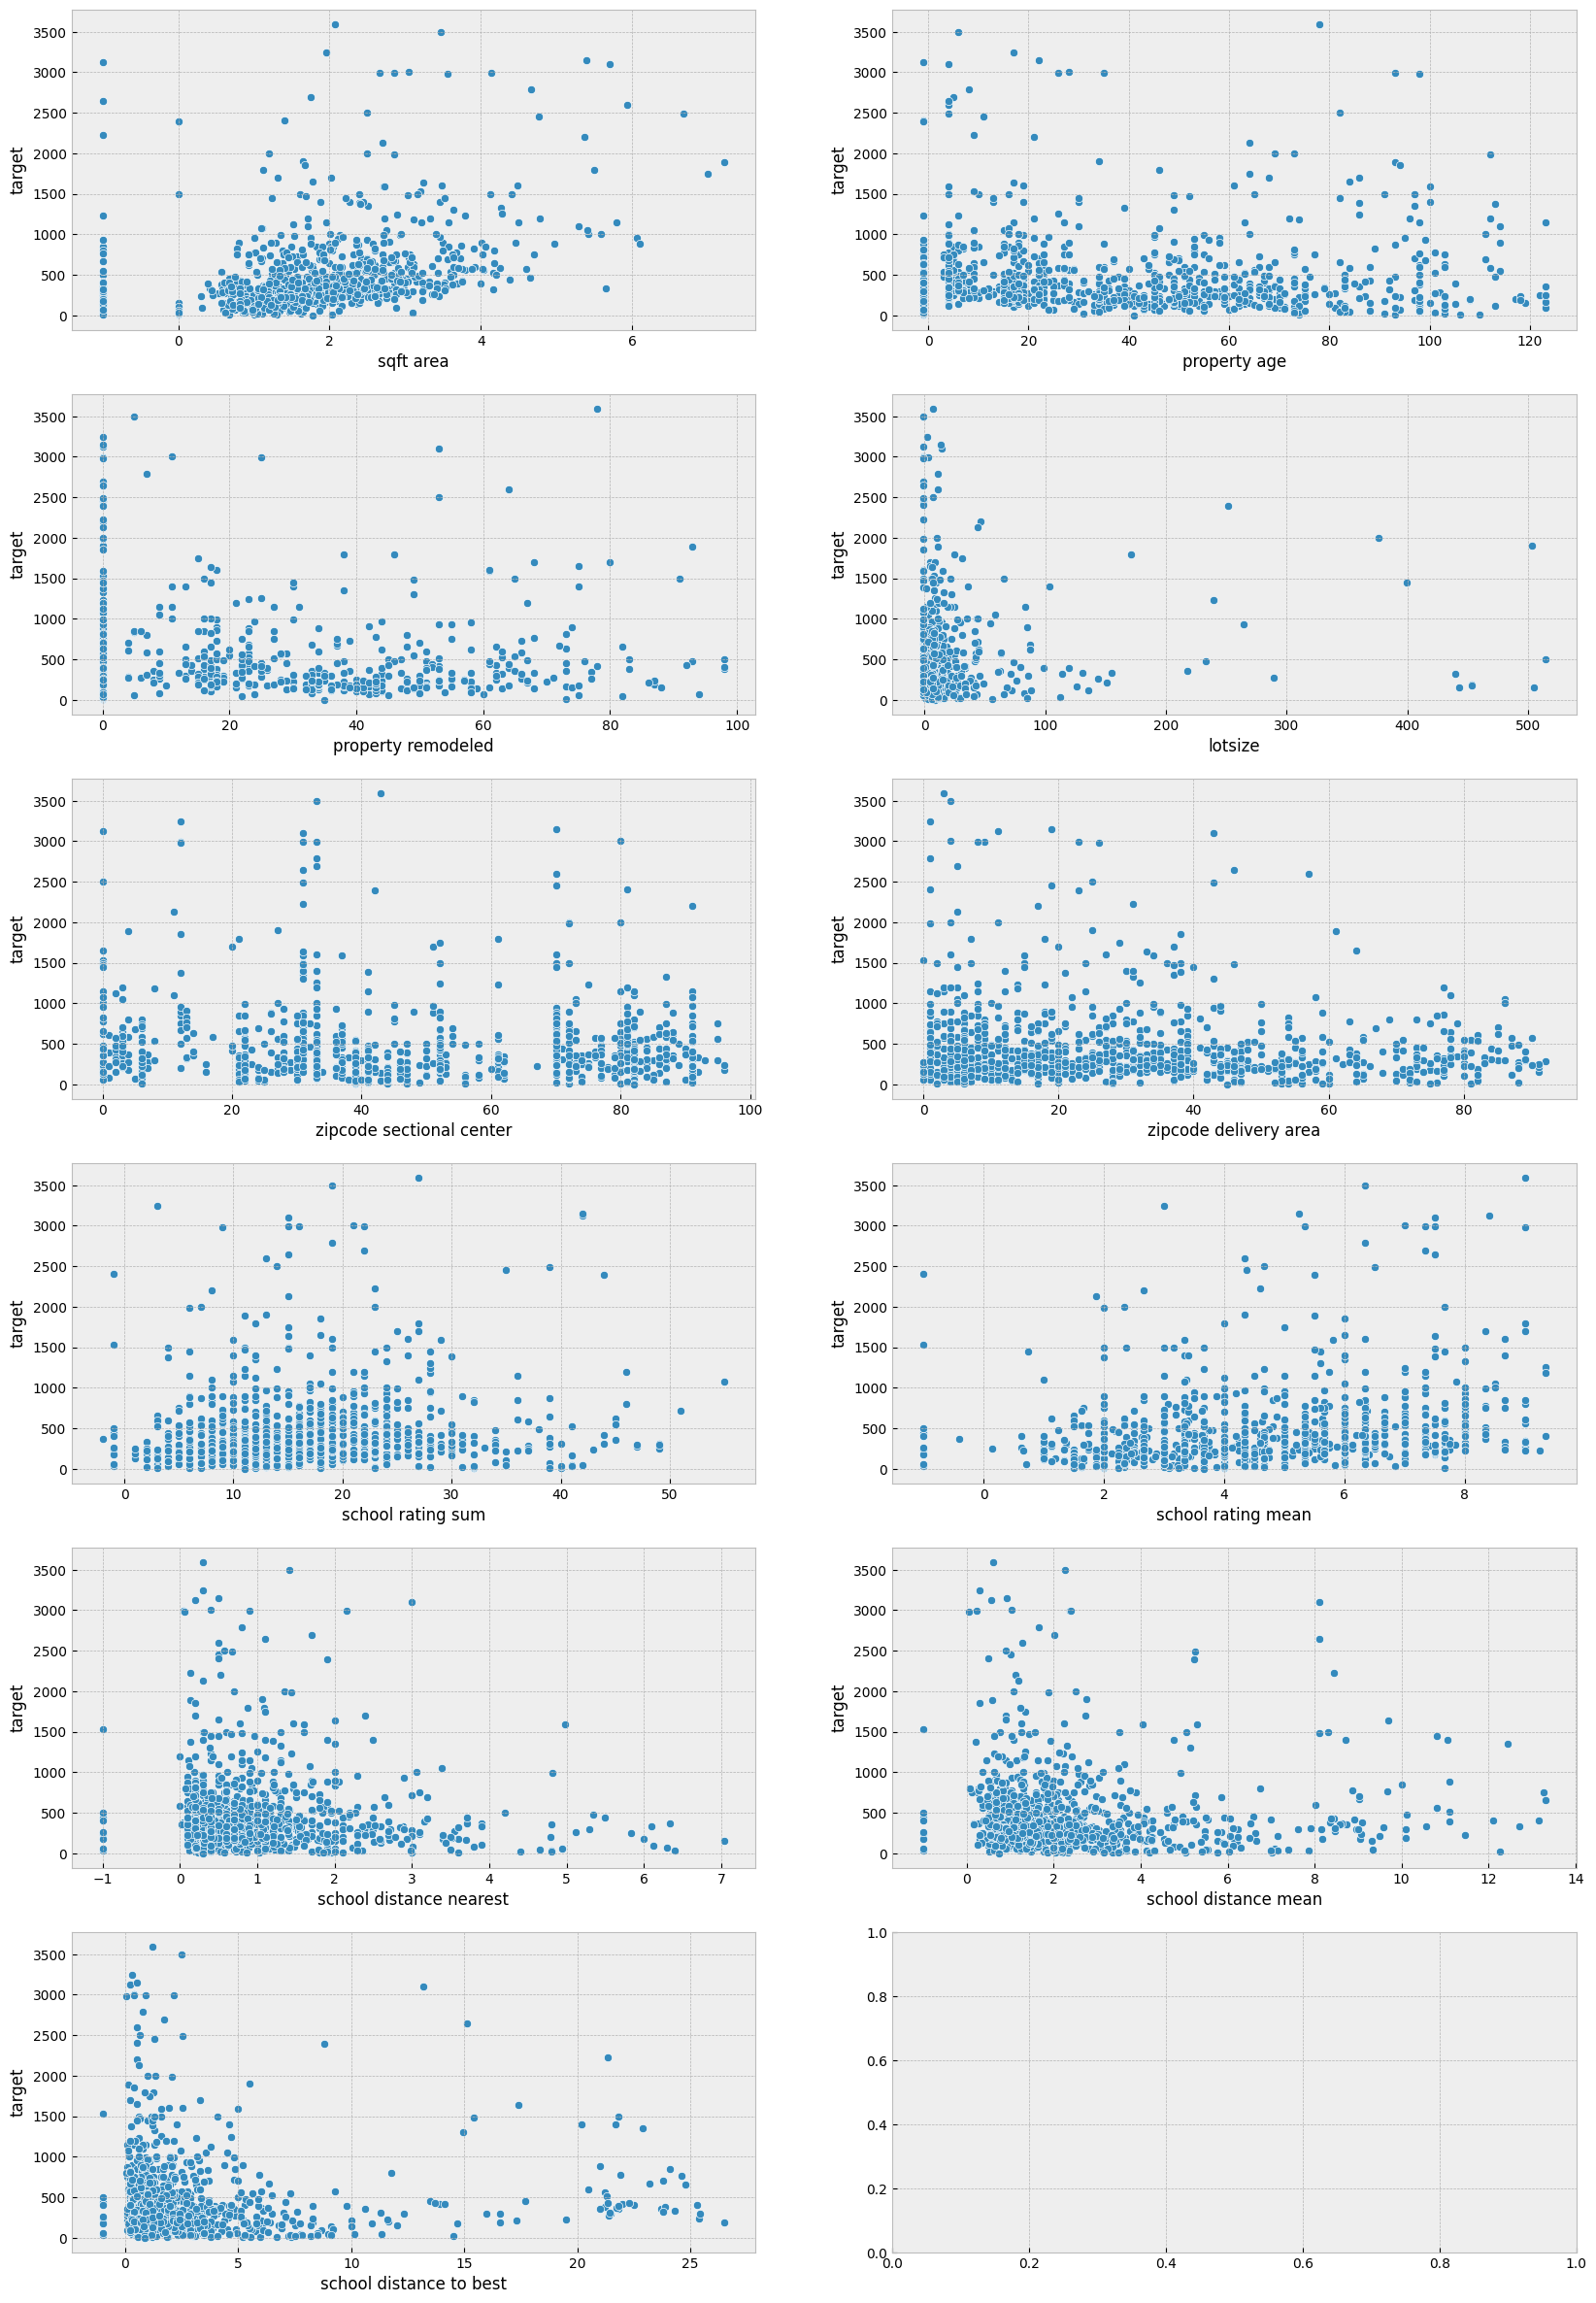

In [17]:
fig, ax = plt.subplots(6, 2, figsize=(20, 30))

for i, col in enumerate(num_cols):
    sample = cleaned_data[[col, 'target']].sample(1000, random_state=R)

    if i % 2 == 0:
        ax_place = ax[i//2, 0]
    else:
        ax_place = ax[i//2, 1]
        
    sns.scatterplot(sample, x=col, y='target', ax=ax_place)
    
fig.show()

### Масштабирование данных

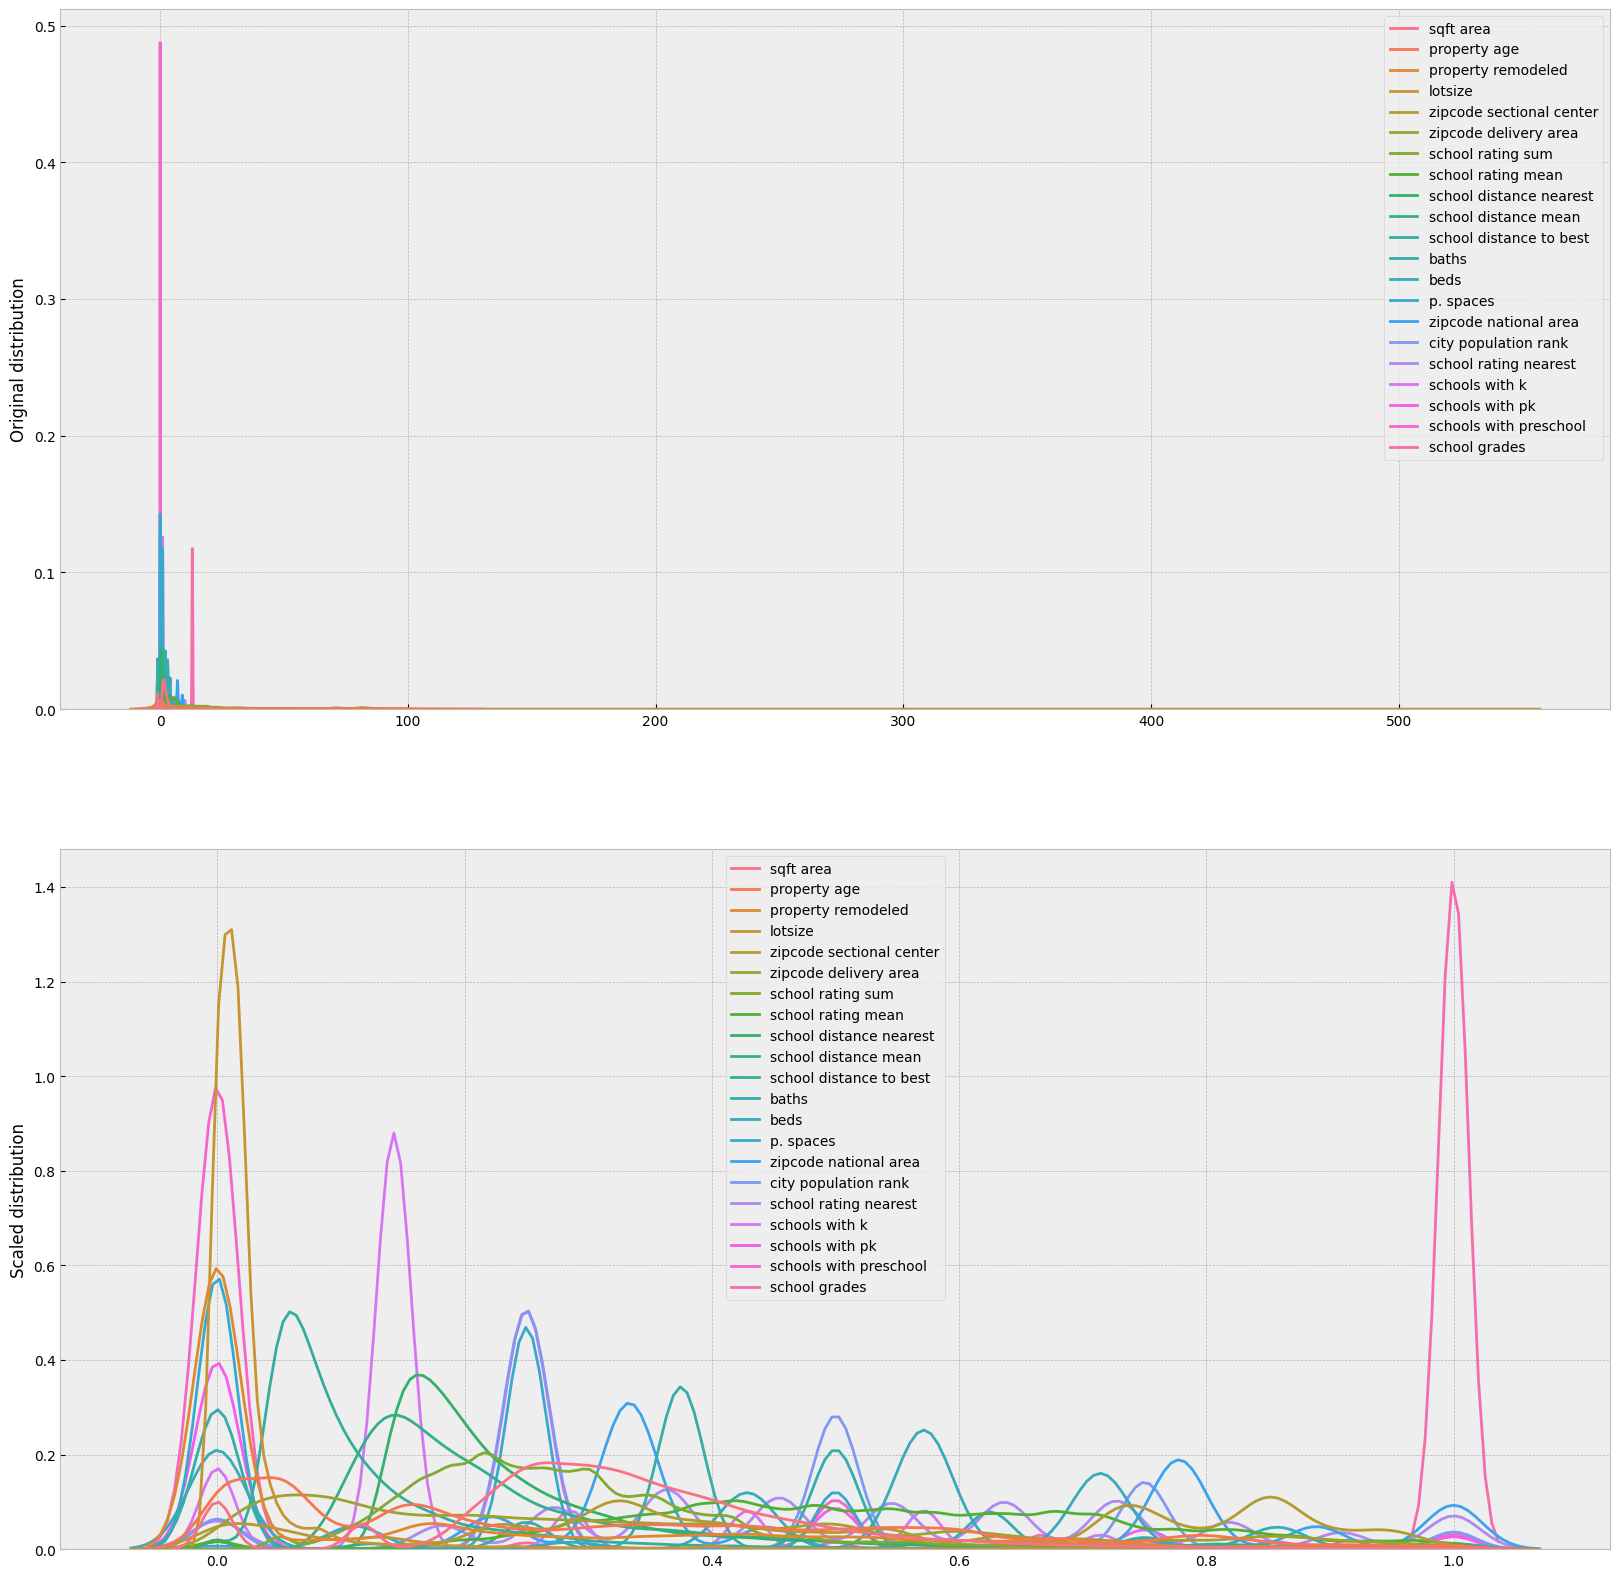

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(20, 20))

num_cols += cat_cols

sns.kdeplot(cleaned_data[num_cols], ax=ax[0])
ax[0].set_ylabel('Original distribution')

scaler = pp.MinMaxScaler()
nums_scaled = pd.DataFrame(scaler.fit_transform(cleaned_data[num_cols]),
                           columns=scaler.feature_names_in_)

sns.kdeplot(nums_scaled, ax=ax[1])
ax[1].set_ylabel('Scaled distribution')

fig.show()

In [19]:
cleaned_data[num_cols] = nums_scaled

cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305219 entries, 0 to 305218
Data columns (total 96 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   status for sale             305219 non-null  int64  
 1   status coming soon          305219 non-null  int64  
 2   status new                  305219 non-null  int64  
 3   status foreclosure          305219 non-null  int64  
 4   status pre-foreclosure      305219 non-null  int64  
 5   status pending              305219 non-null  int64  
 6   status auction              305219 non-null  int64  
 7   status active               305219 non-null  int64  
 8   status show                 305219 non-null  int64  
 9   status for rent             305219 non-null  int64  
 10  status sold                 305219 non-null  int64  
 11  status under contract       305219 non-null  int64  
 12  status contingent           305219 non-null  int64  
 13  status change 

## **Моделирование**

### Деление данных

In [20]:
X_eval = (cleaned_data
          .query('target == 0')
          .drop('target', axis=1))

cleaned_data.drop(X_eval.index, axis=0, inplace=True)

X = cleaned_data.drop(['target'], axis=1)
y = cleaned_data['target']

X_train, X_test, y_train, y_test = ms.train_test_split(X, y, 
                                                       test_size=0.2, 
                                                       random_state=R)


X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_eval.shape

((242924, 95), (60732, 95), (242924,), (60732,), (1563, 95))

### Отбор самых сильных признаков

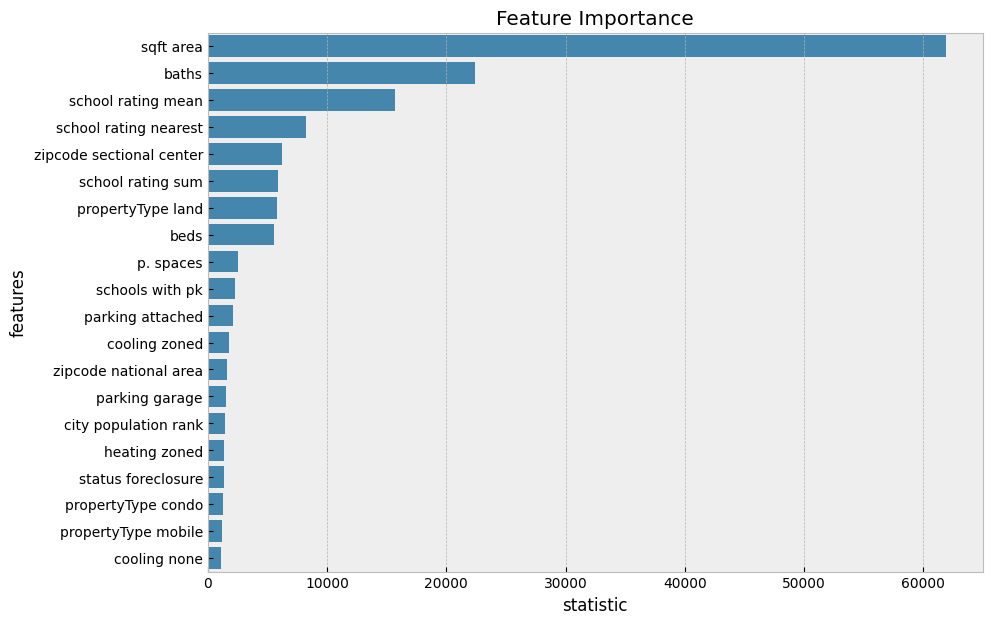

In [21]:
selector = fs.SelectKBest(score_func=fs.f_regression, k=20)
selector.fit(X_train, y_train)

best_feats = selector.get_feature_names_out()

X_train = X_train[best_feats]
X_test = X_test[best_feats]
X_eval = X_eval[best_feats]

selector_scores = pd.DataFrame({'features': selector.feature_names_in_, 
                                'statistic': selector.scores_})

plt.figure(figsize=(10, 7))
sns.barplot(selector_scores.sort_values('statistic', ascending=False)[:20], 
            y='features', 
            x='statistic', 
            orient='h').set_title('Feature Importance')

plt.show()

### Подбор модели

In [22]:
models = pd.DataFrame(columns=['MAE_train', 'MAE_test', 'MAE_difference', 
                               'MAPE_train', 'MAPE_test', 'MAPE_difference',
                               'R2_train', 'R2_test', 'R2_difference', 
                               'Model'])


def regression_estimate(model, 
                        X_train=X_train, 
                        y_train=y_train, 
                        X_test=X_test, 
                        y_test=y_test, 
                        params=None):
    metric_dict = {}
    
    if params is not None:
        rs = ms.RandomizedSearchCV(estimator=model, 
                                   param_distributions=params, 
                                   scoring='neg_mean_absolute_error', 
                                   random_state=R, cv=10, n_jobs=-1) 
        rs.fit(X_train, y_train)
        
        model = rs.best_estimator_
    
    else:
        model.fit(X_train, y_train)
    
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    mae = lambda y_true, y_pred: m.mean_absolute_error(y_true, y_pred).round(2)
    mape = lambda y_true, y_pred: m.mean_absolute_percentage_error(y_true, y_pred).round(2)
    
    metric_dict['MAE_train'] = mae(y_train, train_pred)
    metric_dict['MAE_test'] = mae(y_test, test_pred)
    metric_dict['MAE_difference'] = np.abs(metric_dict['MAE_train'] - 
                                           metric_dict['MAE_test'])
    
    metric_dict['MAPE_train'] = mape(y_train, train_pred)
    metric_dict['MAPE_test'] = mape(y_test, test_pred)
    metric_dict['MAPE_difference'] = np.abs(metric_dict['MAPE_train'] - 
                                            metric_dict['MAPE_test'])
    
    metric_dict['R2_train'] = m.r2_score(y_train, train_pred).round(2)
    metric_dict['R2_test'] = m.r2_score(y_test, test_pred).round(2)
    metric_dict['R2_difference'] = np.abs(metric_dict['R2_train'] - 
                                          metric_dict['R2_test'])
    
    metric_dict['Model'] = model
    
    return metric_dict


def add_metrics_model(model_name, metrics, data=models):    
    data.loc[model_name] = metrics
    
    return data


model_loc = lambda model: models.loc[model, 'Model']


models

,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model


#### *Линейная регрессия (baseline)*

In [23]:
model = lm.LinearRegression()
metrics = regression_estimate(model)

add_metrics_model('Linear', metrics)

,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
Linear,241.22,240.8,0.42,7.54,9.95,2.41,0.34,0.35,0.01,LinearRegression()


#### *Полиномиальная регрессия*

In [24]:
polynom = pp.PolynomialFeatures(degree=2)
polynom.fit(X_train)

X_train_polynom = polynom.transform(X_train)
X_test_polynom = polynom.transform(X_test)

metrics = regression_estimate(model, 
                              X_train=X_train_polynom, 
                              X_test=X_test_polynom)

add_metrics_model('Polynomial', metrics)

,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
Linear,241.22,240.80,0.42,7.54,9.95,2.41,0.34,0.35,0.01,LinearRegression()
Polynomial,192.40,192.59,0.19,6.64,5.63,1.01,0.52,0.52,0.00,LinearRegression()


### Подбор модели с параметрами

#### *Стохастический градиентный спуск*

In [25]:
model = lm.SGDRegressor(random_state=R)
metrics = regression_estimate(model)

add_metrics_model('SGD', metrics).loc[['SGD']]

,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
SGD,242.21,241.78,0.43,7.59,9.87,2.28,0.34,0.35,0.01,SGDRegressor(random_state=7)


In [26]:
params = {'max_iter': [1000, 1e4], 
          'learning_rate': ['invscaling', 'constant'], 
          'eta0': [0.01, 0.001, 0.0001]}

metrics = regression_estimate(model, params=params)

add_metrics_model('SGD', metrics)

,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
Linear,241.22,240.80,0.42,7.54,9.95,2.41,0.34,0.35,0.01,LinearRegression()
Polynomial,192.40,192.59,0.19,6.64,5.63,1.01,0.52,0.52,0.00,LinearRegression()
SGD,232.76,232.99,0.23,6.12,7.17,1.05,0.30,0.31,0.01,"SGDRegressor(learning_rate='constant', random_..."


In [27]:
model_loc('SGD')

SGDRegressor(learning_rate='constant', random_state=7)

#### *Дерево решений*

In [28]:
model = tree.DecisionTreeRegressor(random_state=R)
metrics = regression_estimate(model)

add_metrics_model('Decision Tree', metrics).loc[['Decision Tree']]

,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
Decision Tree,9.45,148.34,138.89,1.31,0.65,0.66,0.98,0.54,0.44,DecisionTreeRegressor(random_state=7)


In [29]:
params = {'max_depth': [6, 8, 10], 
          'min_samples_split': [1, 2, 3], 
          'min_samples_leaf': [1, 2, 3, 4]}

metrics = regression_estimate(model, params=params)

add_metrics_model('Decision Tree', metrics)

,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
Linear,241.22,240.80,0.42,7.54,9.95,2.41,0.34,0.35,0.01,LinearRegression()
Polynomial,192.40,192.59,0.19,6.64,5.63,1.01,0.52,0.52,0.00,LinearRegression()
SGD,232.76,232.99,0.23,6.12,7.17,1.05,0.30,0.31,0.01,"SGDRegressor(learning_rate='constant', random_..."
Decision Tree,164.27,171.37,7.10,7.97,8.39,0.42,0.64,0.60,0.04,"DecisionTreeRegressor(max_depth=10, min_sample..."


In [30]:
model_loc('Decision Tree')

DecisionTreeRegressor(max_depth=10, min_samples_leaf=3, min_samples_split=3,
                      random_state=7)

#### *Случайный лес*

In [31]:
model = ens.RandomForestRegressor(random_state=R, n_jobs=-1)
metrics = regression_estimate(model)

add_metrics_model('Random Forest', metrics).loc[['Random Forest']]

,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
Random Forest,48.49,118.8,70.31,4.3,3.19,1.11,0.95,0.74,0.21,"(DecisionTreeRegressor(max_features=1.0, rando..."


In [32]:
model = ens.RandomForestRegressor(n_estimators=500, 
                                  max_depth=10,
                                  min_samples_leaf=3,
                                  random_state=R, n_jobs=-1)

metrics = regression_estimate(model)

add_metrics_model('Random Forest', metrics)

,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
Linear,241.22,240.80,0.42,7.54,9.95,2.41,0.34,0.35,0.01,LinearRegression()
Polynomial,192.40,192.59,0.19,6.64,5.63,1.01,0.52,0.52,0.00,LinearRegression()
SGD,232.76,232.99,0.23,6.12,7.17,1.05,0.30,0.31,0.01,"SGDRegressor(learning_rate='constant', random_..."
Decision Tree,164.27,171.37,7.10,7.97,8.39,0.42,0.64,0.60,0.04,"DecisionTreeRegressor(max_depth=10, min_sample..."
Random Forest,154.68,160.42,5.74,8.40,7.77,0.63,0.68,0.65,0.03,"(DecisionTreeRegressor(max_depth=10, max_featu..."


In [33]:
model_loc('Random Forest')

RandomForestRegressor(max_depth=10, min_samples_leaf=3, n_estimators=500,
                      n_jobs=-1, random_state=7)

#### *Стекинг*

In [34]:
estimators = [('lr', model_loc('Linear')), 
              ('sgd', model_loc('SGD')), 
              ('dt', model_loc('Decision Tree'))]
final_estimator = ens.RandomForestRegressor(max_depth=10, random_state=R)

model = ens.StackingRegressor(estimators=estimators, 
                              final_estimator=final_estimator, 
                              cv=5, n_jobs=-1)

metrics = regression_estimate(model)

add_metrics_model('Stacking', metrics)

,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
Linear,241.22,240.80,0.42,7.54,9.95,2.41,0.34,0.35,0.01,LinearRegression()
Polynomial,192.40,192.59,0.19,6.64,5.63,1.01,0.52,0.52,0.00,LinearRegression()
SGD,232.76,232.99,0.23,6.12,7.17,1.05,0.30,0.31,0.01,"SGDRegressor(learning_rate='constant', random_..."
Decision Tree,164.27,171.37,7.10,7.97,8.39,0.42,0.64,0.60,0.04,"DecisionTreeRegressor(max_depth=10, min_sample..."
Random Forest,154.68,160.42,5.74,8.40,7.77,0.63,0.68,0.65,0.03,"(DecisionTreeRegressor(max_depth=10, max_featu..."
Stacking,166.91,173.12,6.21,8.72,9.05,0.33,0.63,0.60,0.03,"StackingRegressor(cv=5,\n est..."


In [35]:
model_loc('Stacking') 

StackingRegressor(cv=5,
                  estimators=[('lr', LinearRegression()),
                              ('sgd',
                               SGDRegressor(learning_rate='constant',
                                            random_state=7)),
                              ('dt',
                               DecisionTreeRegressor(max_depth=10,
                                                     min_samples_leaf=3,
                                                     min_samples_split=3,
                                                     random_state=7))],
                  final_estimator=RandomForestRegressor(max_depth=10,
                                                        random_state=7),
                  n_jobs=-1)

### Бустинг

#### *Адаптивный бустинг*

In [36]:
model = ens.AdaBoostRegressor(random_state=R)
metrics = regression_estimate(model)

add_metrics_model('Adaptive Boosting', metrics).loc[['Adaptive Boosting']]

,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
Adaptive Boosting,341.16,341.64,0.48,19.4,11.85,7.55,0.17,0.18,0.01,"(DecisionTreeRegressor(max_depth=3, random_sta..."


In [37]:
model = ens.AdaBoostRegressor(estimator=model_loc('Decision Tree'), 
                              n_estimators=100, 
                              random_state=R)

metrics = regression_estimate(model)

add_metrics_model('Adaptive Boosting', metrics)

,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
Linear,241.22,240.80,0.42,7.54,9.95,2.41,0.34,0.35,0.01,LinearRegression()
Polynomial,192.40,192.59,0.19,6.64,5.63,1.01,0.52,0.52,0.00,LinearRegression()
SGD,232.76,232.99,0.23,6.12,7.17,1.05,0.30,0.31,0.01,"SGDRegressor(learning_rate='constant', random_..."
Decision Tree,164.27,171.37,7.10,7.97,8.39,0.42,0.64,0.60,0.04,"DecisionTreeRegressor(max_depth=10, min_sample..."
Random Forest,154.68,160.42,5.74,8.40,7.77,0.63,0.68,0.65,0.03,"(DecisionTreeRegressor(max_depth=10, max_featu..."
Stacking,166.91,173.12,6.21,8.72,9.05,0.33,0.63,0.60,0.03,"StackingRegressor(cv=5,\n est..."
Adaptive Boosting,368.60,374.67,6.07,22.73,14.01,8.72,0.12,0.07,0.05,"(DecisionTreeRegressor(max_depth=10, min_sampl..."


In [38]:
model_loc('Adaptive Boosting')

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=10,
                                                  min_samples_leaf=3,
                                                  min_samples_split=3,
                                                  random_state=7),
                  n_estimators=100, random_state=7)

#### *Градиентный бустинг*

In [39]:
model = ens.GradientBoostingRegressor(random_state=R)
metrics = regression_estimate(model)

add_metrics_model('Gradient Boosting', metrics).loc[['Gradient Boosting']]

,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
Gradient Boosting,173.46,173.97,0.51,8.44,7.41,1.03,0.58,0.58,0.0,([DecisionTreeRegressor(criterion='friedman_ms...


In [40]:
model = ens.GradientBoostingRegressor(n_estimators=300, 
                                      criterion='squared_error',
                                      max_depth=6, 
                                      random_state=R)

metrics = regression_estimate(model)

add_metrics_model('Gradient Boosting', metrics)

,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
Linear,241.22,240.80,0.42,7.54,9.95,2.41,0.34,0.35,0.01,LinearRegression()
Polynomial,192.40,192.59,0.19,6.64,5.63,1.01,0.52,0.52,0.00,LinearRegression()
SGD,232.76,232.99,0.23,6.12,7.17,1.05,0.30,0.31,0.01,"SGDRegressor(learning_rate='constant', random_..."
Decision Tree,164.27,171.37,7.10,7.97,8.39,0.42,0.64,0.60,0.04,"DecisionTreeRegressor(max_depth=10, min_sample..."
Random Forest,154.68,160.42,5.74,8.40,7.77,0.63,0.68,0.65,0.03,"(DecisionTreeRegressor(max_depth=10, max_featu..."
Stacking,166.91,173.12,6.21,8.72,9.05,0.33,0.63,0.60,0.03,"StackingRegressor(cv=5,\n est..."
Adaptive Boosting,368.60,374.67,6.07,22.73,14.01,8.72,0.12,0.07,0.05,"(DecisionTreeRegressor(max_depth=10, min_sampl..."
Gradient Boosting,128.27,136.13,7.86,7.80,3.50,4.30,0.76,0.72,0.04,"([DecisionTreeRegressor(max_depth=6,\n ..."


In [41]:
model_loc('Gradient Boosting')

GradientBoostingRegressor(criterion='squared_error', max_depth=6,
                          n_estimators=300, random_state=7)

#### *Бустинг-регрессия от `xgboost`*

In [42]:
model = xgb.XGBRegressor()
metrics = regression_estimate(model)

add_metrics_model('XGBoost', metrics).loc[['XGBoost']]

,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
XGBoost,131.23,138.82,7.59,7.43,3.67,3.76,0.75,0.71,0.04,"XGBRegressor(base_score=None, booster=None, ca..."


In [43]:
model = xgb.XGBRegressor(n_estimators=500, 
                         max_depth=6, 
                         eta=0.1,
                         n_jobs=-1)

metrics = regression_estimate(model)

add_metrics_model('XGBoost', metrics)

,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
Linear,241.22,240.80,0.42,7.54,9.95,2.41,0.34,0.35,0.01,LinearRegression()
Polynomial,192.40,192.59,0.19,6.64,5.63,1.01,0.52,0.52,0.00,LinearRegression()
SGD,232.76,232.99,0.23,6.12,7.17,1.05,0.30,0.31,0.01,"SGDRegressor(learning_rate='constant', random_..."
Decision Tree,164.27,171.37,7.10,7.97,8.39,0.42,0.64,0.60,0.04,"DecisionTreeRegressor(max_depth=10, min_sample..."
Random Forest,154.68,160.42,5.74,8.40,7.77,0.63,0.68,0.65,0.03,"(DecisionTreeRegressor(max_depth=10, max_featu..."
Stacking,166.91,173.12,6.21,8.72,9.05,0.33,0.63,0.60,0.03,"StackingRegressor(cv=5,\n est..."
Adaptive Boosting,368.60,374.67,6.07,22.73,14.01,8.72,0.12,0.07,0.05,"(DecisionTreeRegressor(max_depth=10, min_sampl..."
Gradient Boosting,128.27,136.13,7.86,7.80,3.50,4.30,0.76,0.72,0.04,"([DecisionTreeRegressor(max_depth=6,\n ..."
XGBoost,122.82,132.77,9.95,7.40,2.01,5.39,0.78,0.73,0.05,"XGBRegressor(base_score=None, booster=None, ca..."


In [44]:
model_loc('XGBoost')

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=500, n_jobs=-1,
             num_parallel_tree=None, predictor=None, ...)

#### *Регрессия от `LightGBM`*

In [45]:
model = lgbm.LGBMRegressor(random_state=R, n_jobs=-1)
metrics = regression_estimate(model)

add_metrics_model('LightGBM', metrics).loc[['LightGBM']]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 242924, number of used features: 20
[LightGBM] [Info] Start training from score 450.785405


,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
LightGBM,145.77,148.48,2.71,7.63,5.59,2.04,0.69,0.68,0.01,"LGBMRegressor(n_jobs=-1, random_state=7)"


In [46]:
params = {'max_depth': [3, 5, 10], 
          'n_estimators': [100, 300, 500], 
          'learning_rate': [0.1, 0.01]} 

metrics = regression_estimate(model, params=params)

add_metrics_model('LightGBM', metrics)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 242924, number of used features: 20
[LightGBM] [Info] Start training from score 450.785405
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leav

,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
Linear,241.22,240.80,0.42,7.54,9.95,2.41,0.34,0.35,0.01,LinearRegression()
Polynomial,192.40,192.59,0.19,6.64,5.63,1.01,0.52,0.52,0.00,LinearRegression()
SGD,232.76,232.99,0.23,6.12,7.17,1.05,0.30,0.31,0.01,"SGDRegressor(learning_rate='constant', random_..."
Decision Tree,164.27,171.37,7.10,7.97,8.39,0.42,0.64,0.60,0.04,"DecisionTreeRegressor(max_depth=10, min_sample..."
Random Forest,154.68,160.42,5.74,8.40,7.77,0.63,0.68,0.65,0.03,"(DecisionTreeRegressor(max_depth=10, max_featu..."
Stacking,166.91,173.12,6.21,8.72,9.05,0.33,0.63,0.60,0.03,"StackingRegressor(cv=5,\n est..."
Adaptive Boosting,368.60,374.67,6.07,22.73,14.01,8.72,0.12,0.07,0.05,"(DecisionTreeRegressor(max_depth=10, min_sampl..."
Gradient Boosting,128.27,136.13,7.86,7.80,3.50,4.30,0.76,0.72,0.04,"([DecisionTreeRegressor(max_depth=6,\n ..."
XGBoost,122.82,132.77,9.95,7.40,2.01,5.39,0.78,0.73,0.05,"XGBRegressor(base_score=None, booster=None, ca..."
LightGBM,125.81,133.07,7.26,7.28,3.62,3.66,0.77,0.73,0.04,"LGBMRegressor(max_depth=10, n_estimators=500, ..."


In [47]:
model_loc('LightGBM')

LGBMRegressor(max_depth=10, n_estimators=500, n_jobs=-1, random_state=7)

#### *Регрессия от `CatBoost`*

In [48]:
model = cb.CatBoostRegressor(random_state=R, verbose=False)
metrics = regression_estimate(model)

add_metrics_model('CatBoost', metrics).loc[['CatBoost']]

,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
CatBoost,130.69,135.68,4.99,7.55,1.94,5.61,0.75,0.72,0.03,<catboost.core.CatBoostRegressor object at 0x0...


In [49]:
model = cb.CatBoostRegressor(learning_rate=0.01, 
                             max_depth=10,
                             n_estimators=1000,  
                             eval_metric='MAE', 
                             random_state=R, verbose=False)

metrics = regression_estimate(model)

add_metrics_model('CatBoost', metrics)

,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
Linear,241.22,240.80,0.42,7.54,9.95,2.41,0.34,0.35,0.01,LinearRegression()
Polynomial,192.40,192.59,0.19,6.64,5.63,1.01,0.52,0.52,0.00,LinearRegression()
SGD,232.76,232.99,0.23,6.12,7.17,1.05,0.30,0.31,0.01,"SGDRegressor(learning_rate='constant', random_..."
Decision Tree,164.27,171.37,7.10,7.97,8.39,0.42,0.64,0.60,0.04,"DecisionTreeRegressor(max_depth=10, min_sample..."
Random Forest,154.68,160.42,5.74,8.40,7.77,0.63,0.68,0.65,0.03,"(DecisionTreeRegressor(max_depth=10, max_featu..."
Stacking,166.91,173.12,6.21,8.72,9.05,0.33,0.63,0.60,0.03,"StackingRegressor(cv=5,\n est..."
Adaptive Boosting,368.60,374.67,6.07,22.73,14.01,8.72,0.12,0.07,0.05,"(DecisionTreeRegressor(max_depth=10, min_sampl..."
Gradient Boosting,128.27,136.13,7.86,7.80,3.50,4.30,0.76,0.72,0.04,"([DecisionTreeRegressor(max_depth=6,\n ..."
XGBoost,122.82,132.77,9.95,7.40,2.01,5.39,0.78,0.73,0.05,"XGBRegressor(base_score=None, booster=None, ca..."
LightGBM,125.81,133.07,7.26,7.28,3.62,3.66,0.77,0.73,0.04,"LGBMRegressor(max_depth=10, n_estimators=500, ..."


In [50]:
model_loc('CatBoost').get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'MAE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 7,
 'depth': 10,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.009999999776482582,
 'score_function': 

### Прочие модели

#### *Экстра-дерево*

In [51]:
model = tree.ExtraTreeRegressor(random_state=R)
metrics = regression_estimate(model)

add_metrics_model('Extra Tree', metrics).loc[['Extra Tree']]

,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
Extra Tree,9.45,155.92,146.47,1.31,0.62,0.69,0.98,0.5,0.48,ExtraTreeRegressor(random_state=7)


In [52]:
model.set_params(**model_loc('Decision Tree').get_params())
metrics = regression_estimate(model)

add_metrics_model('Extra Tree', metrics)

,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
Linear,241.22,240.80,0.42,7.54,9.95,2.41,0.34,0.35,0.01,LinearRegression()
Polynomial,192.40,192.59,0.19,6.64,5.63,1.01,0.52,0.52,0.00,LinearRegression()
SGD,232.76,232.99,0.23,6.12,7.17,1.05,0.30,0.31,0.01,"SGDRegressor(learning_rate='constant', random_..."
Decision Tree,164.27,171.37,7.10,7.97,8.39,0.42,0.64,0.60,0.04,"DecisionTreeRegressor(max_depth=10, min_sample..."
Random Forest,154.68,160.42,5.74,8.40,7.77,0.63,0.68,0.65,0.03,"(DecisionTreeRegressor(max_depth=10, max_featu..."
Stacking,166.91,173.12,6.21,8.72,9.05,0.33,0.63,0.60,0.03,"StackingRegressor(cv=5,\n est..."
Adaptive Boosting,368.60,374.67,6.07,22.73,14.01,8.72,0.12,0.07,0.05,"(DecisionTreeRegressor(max_depth=10, min_sampl..."
Gradient Boosting,128.27,136.13,7.86,7.80,3.50,4.30,0.76,0.72,0.04,"([DecisionTreeRegressor(max_depth=6,\n ..."
XGBoost,122.82,132.77,9.95,7.40,2.01,5.39,0.78,0.73,0.05,"XGBRegressor(base_score=None, booster=None, ca..."
LightGBM,125.81,133.07,7.26,7.28,3.62,3.66,0.77,0.73,0.04,"LGBMRegressor(max_depth=10, n_estimators=500, ..."


#### *Экстра-лес*

In [53]:
model = ens.ExtraTreesRegressor(random_state=R, n_jobs=-1)
metrics = regression_estimate(model)

add_metrics_model('Extra Trees', metrics).loc[['Extra Trees']]

,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
Extra Trees,9.45,118.1,108.65,1.31,3.45,2.14,0.98,0.72,0.26,"(ExtraTreeRegressor(random_state=327741615), E..."


In [54]:
model.set_params(**model_loc('Random Forest').get_params())
metrics = regression_estimate(model)

add_metrics_model('Extra Trees', metrics)

,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
Linear,241.22,240.80,0.42,7.54,9.95,2.41,0.34,0.35,0.01,LinearRegression()
Polynomial,192.40,192.59,0.19,6.64,5.63,1.01,0.52,0.52,0.00,LinearRegression()
SGD,232.76,232.99,0.23,6.12,7.17,1.05,0.30,0.31,0.01,"SGDRegressor(learning_rate='constant', random_..."
Decision Tree,164.27,171.37,7.10,7.97,8.39,0.42,0.64,0.60,0.04,"DecisionTreeRegressor(max_depth=10, min_sample..."
Random Forest,154.68,160.42,5.74,8.40,7.77,0.63,0.68,0.65,0.03,"(DecisionTreeRegressor(max_depth=10, max_featu..."
Stacking,166.91,173.12,6.21,8.72,9.05,0.33,0.63,0.60,0.03,"StackingRegressor(cv=5,\n est..."
Adaptive Boosting,368.60,374.67,6.07,22.73,14.01,8.72,0.12,0.07,0.05,"(DecisionTreeRegressor(max_depth=10, min_sampl..."
Gradient Boosting,128.27,136.13,7.86,7.80,3.50,4.30,0.76,0.72,0.04,"([DecisionTreeRegressor(max_depth=6,\n ..."
XGBoost,122.82,132.77,9.95,7.40,2.01,5.39,0.78,0.73,0.05,"XGBRegressor(base_score=None, booster=None, ca..."
LightGBM,125.81,133.07,7.26,7.28,3.62,3.66,0.77,0.73,0.04,"LGBMRegressor(max_depth=10, n_estimators=500, ..."


#### *Голосующая регрессия*

In [55]:
estimators = [('dt', model_loc('Decision Tree')), 
              ('et', model_loc('Extra Tree'))]

model = ens.VotingRegressor(estimators=estimators, n_jobs=-1) 
metrics = regression_estimate(model)

add_metrics_model('Voting', metrics)

,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
Linear,241.22,240.80,0.42,7.54,9.95,2.41,0.34,0.35,0.01,LinearRegression()
Polynomial,192.40,192.59,0.19,6.64,5.63,1.01,0.52,0.52,0.00,LinearRegression()
SGD,232.76,232.99,0.23,6.12,7.17,1.05,0.30,0.31,0.01,"SGDRegressor(learning_rate='constant', random_..."
Decision Tree,164.27,171.37,7.10,7.97,8.39,0.42,0.64,0.60,0.04,"DecisionTreeRegressor(max_depth=10, min_sample..."
Random Forest,154.68,160.42,5.74,8.40,7.77,0.63,0.68,0.65,0.03,"(DecisionTreeRegressor(max_depth=10, max_featu..."
Stacking,166.91,173.12,6.21,8.72,9.05,0.33,0.63,0.60,0.03,"StackingRegressor(cv=5,\n est..."
Adaptive Boosting,368.60,374.67,6.07,22.73,14.01,8.72,0.12,0.07,0.05,"(DecisionTreeRegressor(max_depth=10, min_sampl..."
Gradient Boosting,128.27,136.13,7.86,7.80,3.50,4.30,0.76,0.72,0.04,"([DecisionTreeRegressor(max_depth=6,\n ..."
XGBoost,122.82,132.77,9.95,7.40,2.01,5.39,0.78,0.73,0.05,"XGBRegressor(base_score=None, booster=None, ca..."
LightGBM,125.81,133.07,7.26,7.28,3.62,3.66,0.77,0.73,0.04,"LGBMRegressor(max_depth=10, n_estimators=500, ..."


### Выбор модели и улучшение ее качества

In [56]:
models.query('(R2_test >= 0.5) & (MAPE_test <= 5)', inplace=True)

most_accurate_model = (models
                       .sort_values('MAPE_test')
                       .iloc[0]['Model']) 

least_variant_model = (models
                       .sort_values('MAE_difference')
                       .iloc[0]['Model'])


most_accurate_model, least_variant_model

(XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=-1,
              num_parallel_tree=None, predictor=None, ...),
 LGBMRegressor(max_depth=10, n_estimators=500, n_jobs=-1, random_state=7))

#### *Настройка точности*

In [57]:
models.loc['XGBoost']

MAE_train                                                     122.82
MAE_test                                                      132.77
MAE_difference                                                  9.95
MAPE_train                                                       7.4
MAPE_test                                                       2.01
MAPE_difference                                                 5.39
R2_train                                                        0.78
R2_test                                                         0.73
R2_difference                                                   0.05
Model              XGBRegressor(base_score=None, booster=None, ca...
Name: XGBoost, dtype: object

In [58]:
params = {"learning_rate": [0.05, 0.1, 0.2, 0.3],
          "max_depth": [4, 6, 8, 10],
          "min_child_weight": [1, 3, 5, 7],
          "gamma": [0, 0.1, 0.2, 0.3],
          "colsample_bytree": [0.3, 0.4, 0.5, 0.7]}

metrics = regression_estimate(most_accurate_model, params=params)

metrics

{'MAE_train': 90.28,
 'MAE_test': 120.74,
 'MAE_difference': 30.459999999999994,
 'MAPE_train': 5.88,
 'MAPE_test': 1.23,
 'MAPE_difference': 4.65,
 'R2_train': 0.88,
 'R2_test': 0.76,
 'R2_difference': 0.12,
 'Model': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=0.1, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=-1,
              num_parallel_tree=None, predictor=None, ...)}

In [59]:
params = {'alpha': 50, 'lambda': 70}
most_accurate_model = metrics['Model']

most_accurate_model.set_params(**params)
metrics = regression_estimate(most_accurate_model)

metrics

{'MAE_train': 111.39,
 'MAE_test': 125.5,
 'MAE_difference': 14.11,
 'MAPE_train': 6.64,
 'MAPE_test': 0.77,
 'MAPE_difference': 5.869999999999999,
 'R2_train': 0.81,
 'R2_test': 0.75,
 'R2_difference': 0.06000000000000005,
 'Model': XGBRegressor(alpha=50, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=0.1, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=70,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=-1, ...)}

In [60]:
most_accurate_model = metrics['Model']

most_accurate_model

XGBRegressor(alpha=50, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.4, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=0.1, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None, lambda=70,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=500, n_jobs=-1, ...)

#### *Уменьшение разброса*

In [61]:
models.loc['LightGBM']

MAE_train                                                     125.81
MAE_test                                                      133.07
MAE_difference                                                  7.26
MAPE_train                                                      7.28
MAPE_test                                                       3.62
MAPE_difference                                                 3.66
R2_train                                                        0.77
R2_test                                                         0.73
R2_difference                                                   0.04
Model              LGBMRegressor(max_depth=10, n_estimators=500, ...
Name: LightGBM, dtype: object

In [62]:
params = {"learning_rate": [0.05, 0.1, 0.2, 0.3],
          "max_depth": [4, 6, 8, 10],
          "min_child_weight": [1, 3, 5, 7]}

metrics = regression_estimate(least_variant_model, params=params)

metrics

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 242924, number of used features: 20
[LightGBM] [Info] Start training from score 450.785405
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leav

{'MAE_train': 117.78,
 'MAE_test': 129.36,
 'MAE_difference': 11.580000000000013,
 'MAPE_train': 7.27,
 'MAPE_test': 0.71,
 'MAPE_difference': 6.56,
 'R2_train': 0.8,
 'R2_test': 0.74,
 'R2_difference': 0.06000000000000005,
 'Model': LGBMRegressor(learning_rate=0.2, max_depth=10, min_child_weight=3,
               n_estimators=500, n_jobs=-1, random_state=7)}

In [63]:
params = {'alpha': 100, 'lambda_l2': 200}
least_variant_model = metrics['Model']

least_variant_model.set_params(**params)
metrics = regression_estimate(least_variant_model)

metrics

[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 242924, number of used features: 20
[LightGBM] [Info] Start training from score 450.785405
[LightGBM] [Warning] lambda_l2 is set=200, r

{'MAE_train': 125.39,
 'MAE_test': 132.11,
 'MAE_difference': 6.720000000000013,
 'MAPE_train': 7.15,
 'MAPE_test': 0.84,
 'MAPE_difference': 6.3100000000000005,
 'R2_train': 0.76,
 'R2_test': 0.73,
 'R2_difference': 0.030000000000000027,
 'Model': LGBMRegressor(alpha=100, lambda_l2=200, learning_rate=0.2, max_depth=10,
               min_child_weight=3, n_estimators=500, n_jobs=-1, random_state=7)}

In [64]:
least_variant_model = metrics['Model']

least_variant_model 

LGBMRegressor(alpha=100, lambda_l2=200, learning_rate=0.2, max_depth=10,
              min_child_weight=3, n_estimators=500, n_jobs=-1, random_state=7)

#### *Эксперимент: полиномиальный бустинг*

In [65]:
metrics = regression_estimate(most_accurate_model, 
                              X_train=X_train_polynom, 
                              X_test=X_test_polynom)

metrics

{'MAE_train': 99.73,
 'MAE_test': 122.04,
 'MAE_difference': 22.310000000000002,
 'MAPE_train': 6.39,
 'MAPE_test': 2.8,
 'MAPE_difference': 3.59,
 'R2_train': 0.84,
 'R2_test': 0.75,
 'R2_difference': 0.08999999999999997,
 'Model': XGBRegressor(alpha=50, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=0.1, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=70,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=-1, ...)}

In [66]:
metrics = regression_estimate(least_variant_model, 
                              X_train=X_train_polynom, 
                              X_test=X_test_polynom)

metrics

[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14617
[LightGBM] [Info] Number of data points in the train set: 242924, number of used features: 219
[LightGBM] [Info] Start training from score 450.785405
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

{'MAE_train': 119.77,
 'MAE_test': 129.8,
 'MAE_difference': 10.030000000000015,
 'MAPE_train': 6.56,
 'MAPE_test': 1.75,
 'MAPE_difference': 4.81,
 'R2_train': 0.79,
 'R2_test': 0.74,
 'R2_difference': 0.050000000000000044,
 'Model': LGBMRegressor(alpha=100, lambda_l2=200, learning_rate=0.2, max_depth=10,
               min_child_weight=3, n_estimators=500, n_jobs=-1, random_state=7)}

## **Загрузка моделей**

In [68]:
with open('models/most_accurate.pkl', 'wb') as model_file:
    pickle.dump(most_accurate_model, model_file)
    
with open('models/least_variant.pkl', 'wb') as model_file:
    pickle.dump(least_variant_model, model_file)